[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ClimateMatchAcademy/course-content/blob/main/tutorials/W1D4_Paleoclimate/W1D4_Tutorial7.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/{ORG}/course-content/main/tutorials/W1D4_Paleoclimate/W1D4_Tutorial7.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# **Tutorial 7: Assessing Climate Forcings**
**Week 1, Day 4, Paleoclimate**

**Content creators:** Sloane Garelick

**Content reviewers:** Yosmely Bermúdez, Dionessa Biton, Katrina Dobson, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Brodie Pearson, Jenna Pearson, Mauro Tripaldi, Chi Zhang, Ohad Zivan 

**Content editors:** Yosmely Bermúdez, Zahra Khodakaramimaghsoud, Jenna Pearson, Agustina Pesce, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS and Google deepmind

# **Tutorial Objectives**

In this tutorial, you will use data analysis tools and climate concepts you've learned today, and on previous days, to assess the forcings of climate variations observed in paleoclimate records. 

By the end of this tutorial you will be able to:

*   Plot and interpret temperature reconstructions from speleothem oxygen isotopes
*   Generate and plot time series of solar insolation
*   Assess the orbital forcings on monsoon intensity over the past 400,000 years using spectral analysis

# Setup 

In [1]:
# imports
import pooch
import os
import tempfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs
import pyleoclim as pyleo

from climlab import constants as const
from climlab.solar.orbital import OrbitalTable
from climlab.solar.insolation import daily_insolation

/srv/conda/envs/notebook/lib/python3.10/site-packages/climlab/convection/akmaev_adjustment.py:142: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  Akmaev_adjustment = jit(signature_or_function=Akmaev_adjustment)


Tokenization took: 4.36 ms
Type conversion took: 1.82 ms
Parser memory cleanup took: 0.00 ms


In [2]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video

In [3]:
# helper functions

def pooch_load(filelocation=None,filename=None,processor=None):
    shared_location='/home/jovyan/shared/Data/tutorials/W1D4_Paleoclimate' # this is different for each day
    user_temp_cache=tempfile.gettempdir()
    
    if os.path.exists(os.path.join(shared_location,filename)):
        file = os.path.join(shared_location,filename)
    else:
        file = pooch.retrieve(filelocation,known_hash=None,fname=os.path.join(user_temp_cache,filename),processor=processor)

    return file

# **Section 1: Understanding Climate Forcings**

A common task in paleoclimatology is to relate a proxy record (or several of them) to the particular forcing(s) that is thought to dominate that particular record (e.g., based on the proxy, location, etc.). We've already spent some time in earlier tutorials learning about the influence of Earth's orbital configuration on glacial-interglacial cycles. In this tutorial, we'll assess the the climate forcings of monsoon intensity over the past 400,000 years. 

Recall from the video that monsoons are seasonal changes in the direction of strongest wind and precipitation that are primarily driven by variations in seasonal insolation. Land and the ocean have different abilities to hold onto heat. Land cools and warms much faster than the ocean does due to high heat capacity. This temperature difference leads to a pressure difference that drives atmospheric circulations called monsoons. 

*   **Summer (Northern Hemisphere)**: land is warmer than the ocean, so the winds blow towards the land, resulting in heavy rainfall over land.
*   **Winter (Northern Hemisphere)**: land is cooler than the ocean, so the winds blow away from the land, resulting in heavy rainfall over the ocean and decreased rainfall over land.
 

On longer timescales, changes in insolation and the mean climate state can drive changes in monsoon intensity. To assess these long-term changes, we can analyze paleoclimate reconstructions from monsoon regions such as India, Southeast Asia or Africa.  δ<sup>18</sup>O records from speleothems in Chinese caves are broadly interpreted to reflect continental-scale monsoon circulations. 

In this tutorial we'll plot and analyze a composite of three δ<sup>18</sup>O speleothem records from multiple caves in China (Sanbao, Hulu, and Dongge caves) from [Cheng et al. (2016)](https://hwww.nature.com/articles/nature18591). We will then assess the relationship between the climate signals recorded by the speleothem δ<sup>18</sup>O and solar insolation.

First, we can download and plot the speleothem oxygen isotope data:

Time axis values sorted in ascending order


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [ka]', ylabel='$\\delta^{18}$O [‰]'>)

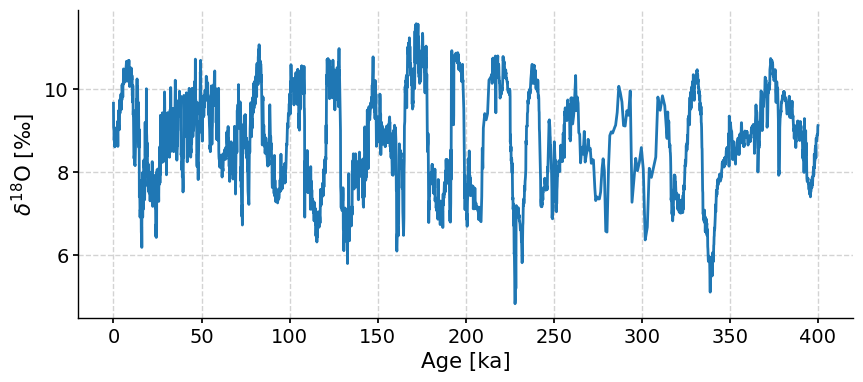

In [5]:
# download the data from the url
filename_Sanbao_composite='Sanbao_composite.csv'
url_Sanbao_composite='https://raw.githubusercontent.com/LinkedEarth/paleoHackathon/main/data/Orbital_records/Sanbao_composite.csv'
data = pd.read_csv(pooch_load(filelocation=url_Sanbao_composite,filename=filename_Sanbao_composite))

# create a pyleo.Series
d18O_data = pyleo.Series(
    time=data['age']/1000,
    time_name='Age',
    time_unit='kyr BP',
    value=-data['d18O'],
    value_name=r'$\delta^{18}$O',
    value_unit=u'\u2030'
)
d18O_data.plot()

You may notice that in the figure we just made, the δ<sup>18</sup>O values on the y-axis is plotted with more positive values up, whereas in previous tutorials, we've plotted isotopic data with more negative values up (since more negative/"depleted" suggests warmer temperatures or increased rainfall). However, the pre-processed δ<sup>18</sup>O data that we're using in this tutorial was multipled by -1, so now a more positive/"enriched" value suggests warmer temperatures or increased rainfall. In other words, in this figure, upward on the y-axis is increased monsoon intensity and downward on the y-axis is decreased monsoon intensity.

Let's apply what we learned in the previous tutorial to perform spectral analysis on the speleothem oxygen isotope data. Recall from the previous tutorial that spectral analysis can help us identify dominant cyclicities in the data, which can be useful for assessing potential climate forcings.

Here we'll use the Weighted Wavelet Z-Transform (WWZ) method you learned about in the previous tutorial:

In [6]:
# standardize the data
d18O_stnd = d18O_data.interp(step=0.5).standardize() # save it for future use

In [7]:
# calculate the WWZ spectral analysis
d18O_wwz = d18O_stnd.spectral(method='wwz')

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [kas]', ylabel='PSD'>)

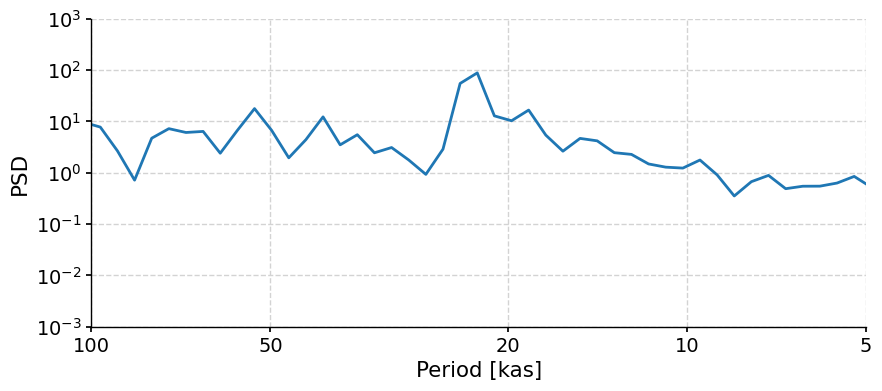

In [8]:
# plot WWZ results
d18O_wwz.plot(xlim=[100, 5],ylim=[0.001, 1000])

## Coding Exercises 1

1. The dominant spectral power is at ~23,000 years. This suggests a link between monsoon intensity and orbital precession! Is this peak significant? Use the skills you learned in the last tutorial to test the significance of this peak at the 95% confidence level. For this exercise, input `number = 5` as the default value which will take a long time to run.

note: if you have time, change the number to `30`. it will take about 5-10 minutes to run 

In [11]:
# perform significance test with 5 surrogates
d18O_wwz_sig = ...

# plot the results
...

Ellipsis

Performing spectral analysis on individual series: 100%|██████████| 5/5 [01:07<00:00, 13.43s/it]


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [kyrs]', ylabel='PSD'>)

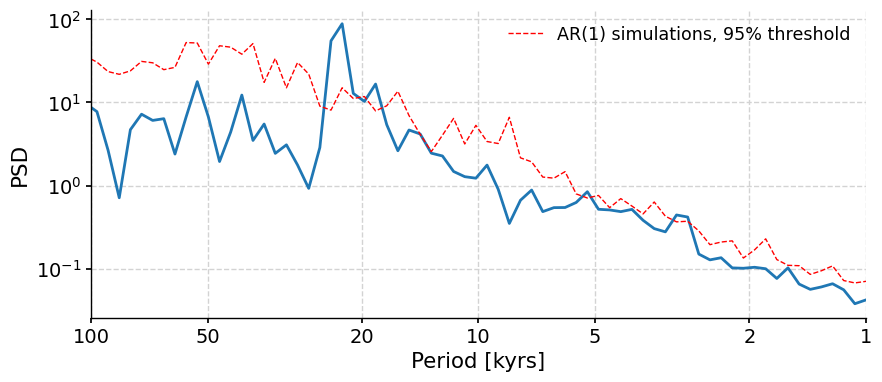

In [12]:
# to_remove solution

# perform significance test with 5 surrogates
d18O_wwz_sig = d18O_wwz.signif_test(number = 5)

# plot the results
d18O_wwz_sig.plot(xlabel='Period [kyrs]')


# **Section 2: Constructing Insolation Curves**

To further explore and confirm the relationship between monsoon intensity and orbital precession, let's take a look at insolation data and compare this to the speleothem δ<sup>18</sup>O records from Asia. Recall that insolation is controlled by variations in Earth's orbital cycles (eccentricity, obliquity, precession), so by comparing the δ<sup>18</sup>O record to insolation, we can assess the influence of orbital variations on δ<sup>18</sup>O and monsoon intensity. 

To compute solar insolation, we can use the package [`climlab`](https://climlab.readthedocs.io/en/latest/index.html) by Brian Rose. Let's create a time series over the past 400,000 years of changes in summer insolation at 31.67ºN, which is the latitude of Sanbao, one of the caves from which the speleothem records were produced.


In [13]:
# specify time interval and units
kyears = np.linspace(-400, 0, 1001 )

# subset of orbital parameters for specified time
orb = OrbitalTable.interp(kyear=kyears)
days = np.linspace(0, const.days_per_year, 365)

# generate insolation at Sanbao latitude (31.67)
Qsb = daily_insolation(31.67, days, orb)

# julian days 152-243 are JJA
Qsb_jja = np.mean(Qsb[:,151:243], axis=1)

Now we can store this data as a `Series` in Pyleoclim and plot the data versus time:

Time axis values sorted in ascending order


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [ka]', ylabel='JJA Insolation [$W.m^{-2}$]'>)

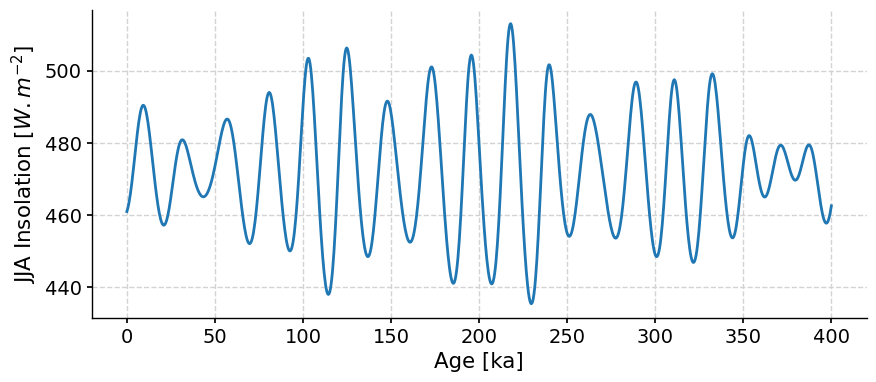

In [14]:
ts_qsb = pyleo.Series(
    time=-kyears,
    time_name='Age',
    time_unit='ky BP',
    value=Qsb_jja,
    value_name='JJA Insolation',
    value_unit=r'$W.m^{-2}$'
)

ts_qsb.plot()

Next, let's plot and compare the speleothem δ<sup>18</sup>O data and the solar insolation data:

(<Figure size 640x480 with 3 Axes>,
 {0: <Axes: ylabel='$\\delta^{18}$O [‰]'>,
  1: <Axes: ylabel='JJA Insolation [$W.m^{-2}$]'>,
  2: <Axes: xlabel='Age [ka]'>})

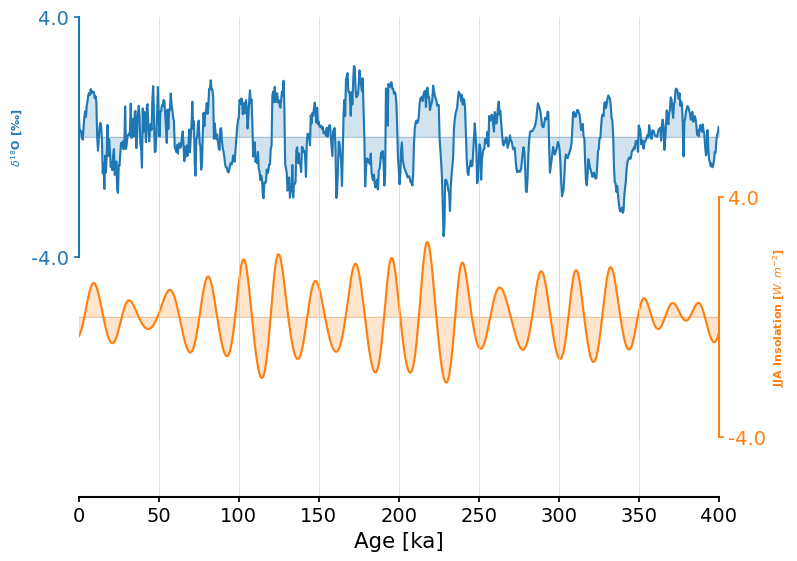

In [15]:
# standardize the insolation data
ts_qsb_stnd = ts_qsb.standardize()

# create a MultipleSeries of the speleothem d18O record and insolation data
compare = [d18O_stnd, ts_qsb_stnd]
ms_compare = pyleo.MultipleSeries(compare, time_unit='kyr BP', name=None)

# create a stackplot to compare the data
ms_compare.stackplot()

By visually comparing the time series of the two records, we can see similarites at orbital scales. To confirm this, we can use spectral analysis to determine the dominant spectral power of the insolation data:

In [16]:
# calculate the WWZ spectral analysis
psd_wwz = ts_qsb_stnd.spectral(method='wwz')

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [kas]', ylabel='PSD'>)

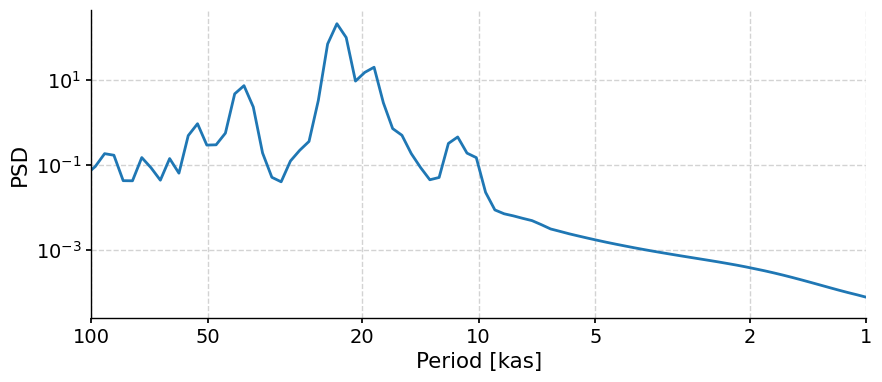

In [17]:
psd_wwz.plot()

## **Questions 2: Climate Connection**

1. What is the dominant spectral power in summer insolation at 31ºN latitude? How does this compare to the speleothem data?
2. Why might there be a relationship between solar insolation and monsoon intensity? What does the common spectral power in both the insolation and δ<sup>18</sup>O records suggest about the climate forcings driving monsoon intensity in this region?

In [ ]:
# to_remove explanation

"""

1. The dominant spectral power for the insolation data is ~23,000 years, which is roughly the same signal observed in the spectral analysis of the speleothem d18O record.
2. The relationship between solar insolation and monsoon intensity can be explained by the fact that solar insolation affects the temperature gradients between land and sea. During the summer, if there's high solar insolation, the land warms up more than the sea, leading to lower pressure over the land. This low pressure attracts moisture-rich air from the sea, causing the monsoon. Therefore, changes in solar insolation caused by Earth's orbital cycles could influence the intensity of monsoons. Specifically, the 23,000 year signal in these records suggests that precession-driven changes in insolation was the dominant forcing of monsoon intensity.
""";

# **Summary**

In this tutorial, you've gained valuable insights into the complex world of paleoclimatology and climate forcings. Here's a recap of what you've learned:
* You've discovered how to plot and interpret temperature reconstructions derived from speleothem oxygen isotopes. 
* You've assessed the likely impact of orbital forcings on monsoon intensity over the past 400,000 years using spectral analysis. 
* By comparing the δ<sup>18</sup>O record to insolation, you've developed a deeper understanding of the relationship between solar insolation and monsoon intensity.

# **Resources**

Code for this tutorial is based on an existing notebook from LinkedEarth that explore [forcing and responses in paleoclimate data](https://github.com/LinkedEarth/paleoHackathon/blob/main/notebooks/PaleoHack-nb04_Forcing%26Response.ipynb).

Data from the following sources are used in this tutorial:

*   Cheng, H., Edwards, R., Sinha, A. et al. The Asian monsoon over the past 640,000 years and ice age terminations. Nature 534, 640–646 (2016). https://doi.org/10.1038/nature18591